# Обучение модели NER на основе spaCy

Проверка качества модели на датасете с маркированными предложениями

## Загрузка библиотек

In [1]:
# cpu
!pip install -U pip setuptools wheel
!pip install -U spacy
!pip install 'spacy[transformers]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.9/807.9 kB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: wheel
    Found existing installation: wheel 0.40.0
    Uninstalling wheel-0.40.0:
      Successfully uninstalled wheel-0.40.0
  Attempting uninstall: setuptools
    Found existing installation: setuptools 68.0.0
    Uninstalling setuptools-68.0.0:
      Successfully uninstalled setuptools-68.0.0
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-api 1.18.0 requires importlib-metadata~=6.0.0, but you have importlib-metadata 6.7.0 which is incompa

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import configparser
import io
import os

import numpy as np
import pandas as pd

import spacy
from spacy.tokens import Doc, DocBin
from spacy import displacy

from tqdm import tqdm
tqdm.pandas()

from sklearn.model_selection import train_test_split

from random import random, randrange, randint

#pd option
pd.options.display.max_columns = 400
pd.options.display.max_rows = 400
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', 1000)

## Загрузка данных

In [4]:
df = pd.read_csv('/kaggle/input/ready-to-learn/ready_to_learn.csv') #

In [5]:
for col in df.columns:
    df[col] = df[col].apply(eval)

In [6]:
df.head(3)

,tokens,bioes_metric
0,"[Меня, зовут, Сергей, ,, Представляю, официальный, дилерский, центр, Аур, Моторс, Жито, в, Санкт, Петербурге, ., Аур, Моторс, .]","[O, O, S-PER, O, O, O, O, O, B-ORG, I-ORG, E-ORG, O, B-LOC, E-LOC, O, B-ORG, E-ORG, O]"
1,"[Это, пятьсот, пятьдесят, тысяч, рублей, ,, подарки, первым, покупателям, ., Уточните, ., было, бы, интересно, рассмотреть, приобретение, автомобиля, в, течение, месяца, .]","[O, B-MONEY, I-MONEY, I-MONEY, E-MONEY, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-DATE, E-DATE, O]"
2,"[Ничего, не, ., ничего, ., надо, ., Не, спасибо, ., Надо, спасибо, .]","[O, O, O, O, O, O, O, O, O, O, O, O, O]"


## Преобразование в формат spaCy

In [7]:
def convert_dataset_row(row):
    '''convert tokens and bioes row in spacy format'''
    converted_data = []
    text = " ".join(row['tokens'])
    entities = []
    token_start = 0
    for j in range(len(row['tokens'])):
        token = row['tokens'][j]
        bioes = row['bioes_metric'][j]
        entity_type = bioes
        entity_start = token_start
        token_start += len(token) + 1
        entity_end = token_start - 1
        if bioes != 'O':
            entities.append((entity_start, entity_end, entity_type))
    converted_data.append((text, entities))
    return converted_data

In [8]:
df['spacy_format'] = df.apply(lambda row: convert_dataset_row(row)[0], axis=1)

In [9]:
df.sample(3)

,tokens,bioes_metric,spacy_format
11464,"[Нет, ,, спасибо, ,, девушка, ., Не, надо, .]","[O, O, O, O, O, O, O, O, O]","(Нет , спасибо , девушка . Не надо ., [])"
1820,"[Меня, зовут, Светлана, ,, я, представляю, автомир, официального, дилера, Москвич, ., Вы, не, планируете, покупку, нового, автомобиля, в, ближайший, месяц, в, Москве, ?]","[O, O, S-PER, O, O, O, S-ORG, O, O, S-PROD, O, O, O, O, O, O, O, O, B-DATE, E-DATE, O, S-LOC, O]","(Меня зовут Светлана , я представляю автомир официального дилера Москвич . Вы не планируете покупку нового автомобиля в ближайший месяц в Москве ?, [(11, 19, S-PER), (36, 43, S-ORG), (64, 71, S-PROD), (119, 128, B-DATE), (129, 134, E-DATE), (137, 143, S-LOC)])"
1613,"[Меня, зовут, Дарья, ,, я, представляю, автомир, официального, дилера, Амода, ., Планируете, ли, вы, покупку, нового, автомобиля, Амода, в, ближайший, месяц, ?]","[O, O, S-PER, O, O, O, S-ORG, O, O, S-PROD, O, O, O, O, O, O, O, S-PROD, O, B-DATE, E-DATE, O]","(Меня зовут Дарья , я представляю автомир официального дилера Амода . Планируете ли вы покупку нового автомобиля Амода в ближайший месяц ?, [(11, 16, S-PER), (33, 40, S-ORG), (61, 66, S-PROD), (112, 117, S-PROD), (120, 129, B-DATE), (130, 135, E-DATE)])"


In [10]:
df[df['tokens'].apply(len) != df['bioes_metric'].apply(len)]

,tokens,bioes_metric,spacy_format


In [11]:
df_ready_to_learn = df['spacy_format'].copy()

## Делим на выборки и конвертируем в *.spacy

In [12]:
train, test = train_test_split(df_ready_to_learn, test_size=0.2, random_state=1) #, stratify
train, dev = train_test_split(train, test_size=0.25, random_state=1)

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
dev = dev.reset_index(drop=True)

train.shape[0], test.shape[0], dev.shape[0]

(7311, 2438, 2437)

In [13]:
def series_to_spacy(ser, name):
    '''Convert pd.Seres to *.spacy'''
    nlp = spacy.blank("ru")
    training_data = ser

    db = DocBin()
    for text, annotations in training_data:
        doc = nlp(text)
        ents = []
        for start, end, label in annotations:
            span = doc.char_span(start, end, label=label)
            ents.append(span)
        doc.ents = ents
        db.add(doc)
    db.to_disk(f"./{name}.spacy")

In [14]:
series_to_spacy(train, 'train')
series_to_spacy(test, 'test')
series_to_spacy(dev, 'dev')

## Сборка конфигурации параметров модели

In [15]:
config_file = configparser.ConfigParser()

s_config = """
# This is an auto-generated partial config. To use it with 'spacy train'
# you can run spacy init fill-config to auto-fill all default settings:
# python -m spacy init fill-config ./base_config.cfg ./config.cfg
[paths]
train = null
dev = null
vectors = null
[system]
gpu_allocator = null

[nlp]
lang = "ru"
pipeline = ["tok2vec","ner"]
batch_size = 1000

[components]

[components.tok2vec]
factory = "tok2vec"

[components.tok2vec.model]
@architectures = "spacy.Tok2Vec.v2"

[components.tok2vec.model.embed]
@architectures = "spacy.MultiHashEmbed.v2"
width = ${components.tok2vec.model.encode.width}
attrs = ["NORM", "PREFIX", "SUFFIX", "SHAPE"]
rows = [5000, 1000, 2500, 2500]
include_static_vectors = true

[components.tok2vec.model.encode]
@architectures = "spacy.MaxoutWindowEncoder.v2"
width = 256
depth = 8
window_size = 1
maxout_pieces = 3

[components.ner]
factory = "ner"

[components.ner.model]
# @architectures = "spacy.TransitionBasedParser.v2"
#state_type = "ner"
#extra_state_tokens = false
#hidden_width = 64
#maxout_pieces = 2
#use_upper = true
#nO = null

[components.ner.model.tok2vec]
#@architectures = "spacy.Tok2VecListener.v1"
#width = ${components.tok2vec.model.encode.width}

[corpora]

[corpora.train]
@readers = "spacy.Corpus.v1"
path = ${paths.train}
max_length = 0

[corpora.dev]
@readers = "spacy.Corpus.v1"
path = ${paths.dev}
max_length = 0

[training]
dev_corpus = "corpora.dev"
train_corpus = "corpora.train"
patience = 800

[training.optimizer]
@optimizers = "Adam.v1"
learn_rate = 0.0002

[training.batcher]
@batchers = "spacy.batch_by_words.v1"
discard_oversize = false
tolerance = 0.2

[training.batcher.size]
@schedules = "compounding.v1"
start = 100
stop = 1000
compound = 1.001

[initialize]
vectors = ${paths.vectors}
"""
buf = io.StringIO(s_config)
config_file.read_file(buf)

with open("base_config.cfg","w") as file_object:
    config_file.write(file_object)

In [16]:
 !python -m spacy init fill-config base_config.cfg config.cfg

✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


# Обучение модели

In [17]:
!python -m spacy train config.cfg --output ./output --paths.train ./train.spacy --paths.dev ./dev.spacy

✔ Created output directory: output
ℹ Saving to output directory: output
ℹ Using CPU

=========================== Initializing pipeline ===========================
[2023-11-07 05:32:12,384] [INFO] Set up nlp object from config
[2023-11-07 05:32:12,429] [INFO] Pipeline: ['tok2vec', 'ner']
[2023-11-07 05:32:12,437] [INFO] Created vocabulary
[2023-11-07 05:32:12,437] [INFO] Finished initializing nlp object
[2023-11-07 05:32:17,372] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.0002
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     44.22    0.00    0.00    0.00    0.00
  0     200          0.00   6338.29   60.00   67.96   53.71    0.60
  0     400          0.00   2006.67   80.38   83.56   77.43    0.80
  0    

# Проверка на тестовом датасете

In [18]:
nlp_trained = spacy.load('/kaggle/working/output/model-best')

In [19]:
!python -m spacy evaluate /kaggle/working/output/model-best --output metrics.json ./test.spacy

ℹ Using CPU

================================== Results ==================================

TOK     100.00
NER P   87.18 
NER R   92.88 
NER F   89.94 
SPEED   2493  


=============================== NER (per type) ===============================

               P       R       F
B-ORG      86.35   85.59   85.97
E-ORG      87.58   85.00   86.27
S-PROD     86.56   92.33   89.35
B-LOC      92.51   98.95   95.62
E-LOC      92.53   99.30   95.80
S-ORG      91.31   95.13   93.18
B-MONEY    75.42   86.41   80.54
I-MONEY    77.83   95.21   85.65
E-MONEY    75.40   92.23   82.97
B-DATE     85.85   95.05   90.22
E-DATE     86.56   96.91   91.44
S-PER      97.98   99.36   98.67
S-LOC      87.13   95.39   91.07
I-DATE     85.88   86.90   86.39
I-ORG      67.54   72.64   70.00
S-DATE     54.35   70.42   61.35
B-PROD     81.91   82.80   82.35
E-PROD     78.95   80.65   79.79
S-MONEY     0.00    0.00    0.00
I-PROD     61.54   50.00   55.17
I-LOC     100.00   16.67   28.57

✔ Saved results to metri

================================== Results ==================================

TOK     100.00\
NER P   96.72 \
NER R   96.72 \
NER F   96.72 \
SPEED   1353  


=============================== NER (per type) ===============================

              P       R       F
> B-MONEY   75.58   70.65   73.03\
> O         98.85   98.24   98.54\
> I-MONEY   73.78   87.83   80.19\
> B-ORG     82.24   84.89   83.54\
> B-LOC     90.64   97.48   93.93\
> B-DATE    81.12   90.99   85.77\
> I-ORG     64.18   40.57   49.71\
> S-ORG     93.75   94.20   93.98\
> S-PER     97.59   99.71   98.64\
> S-PROD    83.19   91.55   87.17\
> B-PROD    66.67   53.01   59.06\
> S-LOC     86.20   93.29   89.60\
> E-DATE    83.61   94.66   88.79\
> E-ORG     87.24   81.35   84.19\
> E-PROD    85.42   49.40   62.60\
> I-DATE    71.00   81.61   75.94\
> E-LOC     88.15   96.36   92.07\
> E-MONEY   80.72   85.90   83.23\
> I-PROD    42.86   15.00   22.22\
> S-DATE    67.35   43.42   52.80\
> I-LOC      0.00    0.00    0.00\
> B-PER      0.00    0.00    0.00\
> S-MONEY    0.00    0.00    0.00\

In [40]:
doc = nlp_trained(test.sample().values[0][0])
displacy.render(doc, style='ent', jupyter=True)

In [48]:
doc = nlp_trained(test.sample().values[0][0])
displacy.render(doc, style='ent', jupyter=True)

In [49]:
doc = nlp_trained(test.sample().values[0][0])
displacy.render(doc, style='ent', jupyter=True)

In [23]:
doc = nlp_trained(test.sample().values[0][0])
displacy.render(doc, style='ent', jupyter=True)

In [24]:
doc = nlp_trained(test.sample().values[0][0])
displacy.render(doc, style='ent', jupyter=True)

In [25]:
metric_test = pd.read_csv('/kaggle/input/train-for-deeppavlov/train(3).txt', sep=' ', names=['KEYWORD', 'LABEL'])

In [26]:
def predict_model_test(text):
    doc = nlp_trained(text)
    return [ent.label_ for ent in doc.ents] #ents_label

In [27]:
from tqdm import tqdm
tqdm.pandas()

In [28]:
metric_test['predict'] = metric_test['KEYWORD'].progress_apply(lambda x: predict_model_test(x))

100%|██████████| 163483/163483 [40:36<00:00, 67.11it/s] 


In [29]:
metric_test['predict'] = metric_test['predict'].apply(lambda x: x[0] if len(x)!=0 else np.nan)

In [30]:
metric_test['predict'] = metric_test['predict'].fillna("O")

In [31]:
metric_test['LABEL'].value_counts()

LABEL
O          138333
S-PROD       3769
S-PER        3503
B-DATE       2272
E-DATE       2272
S-ORG        2043
S-LOC        1744
B-ORG        1470
E-ORG        1470
B-LOC        1322
E-LOC        1322
I-MONEY       883
I-ORG         474
B-MONEY       416
E-MONEY       416
B-PROD        413
E-PROD        413
I-DATE        410
S-DATE        386
I-PROD        100
I-LOC          26
S-MONEY        16
B-PER           4
E-PER           4
I-PER           2
Name: count, dtype: int64

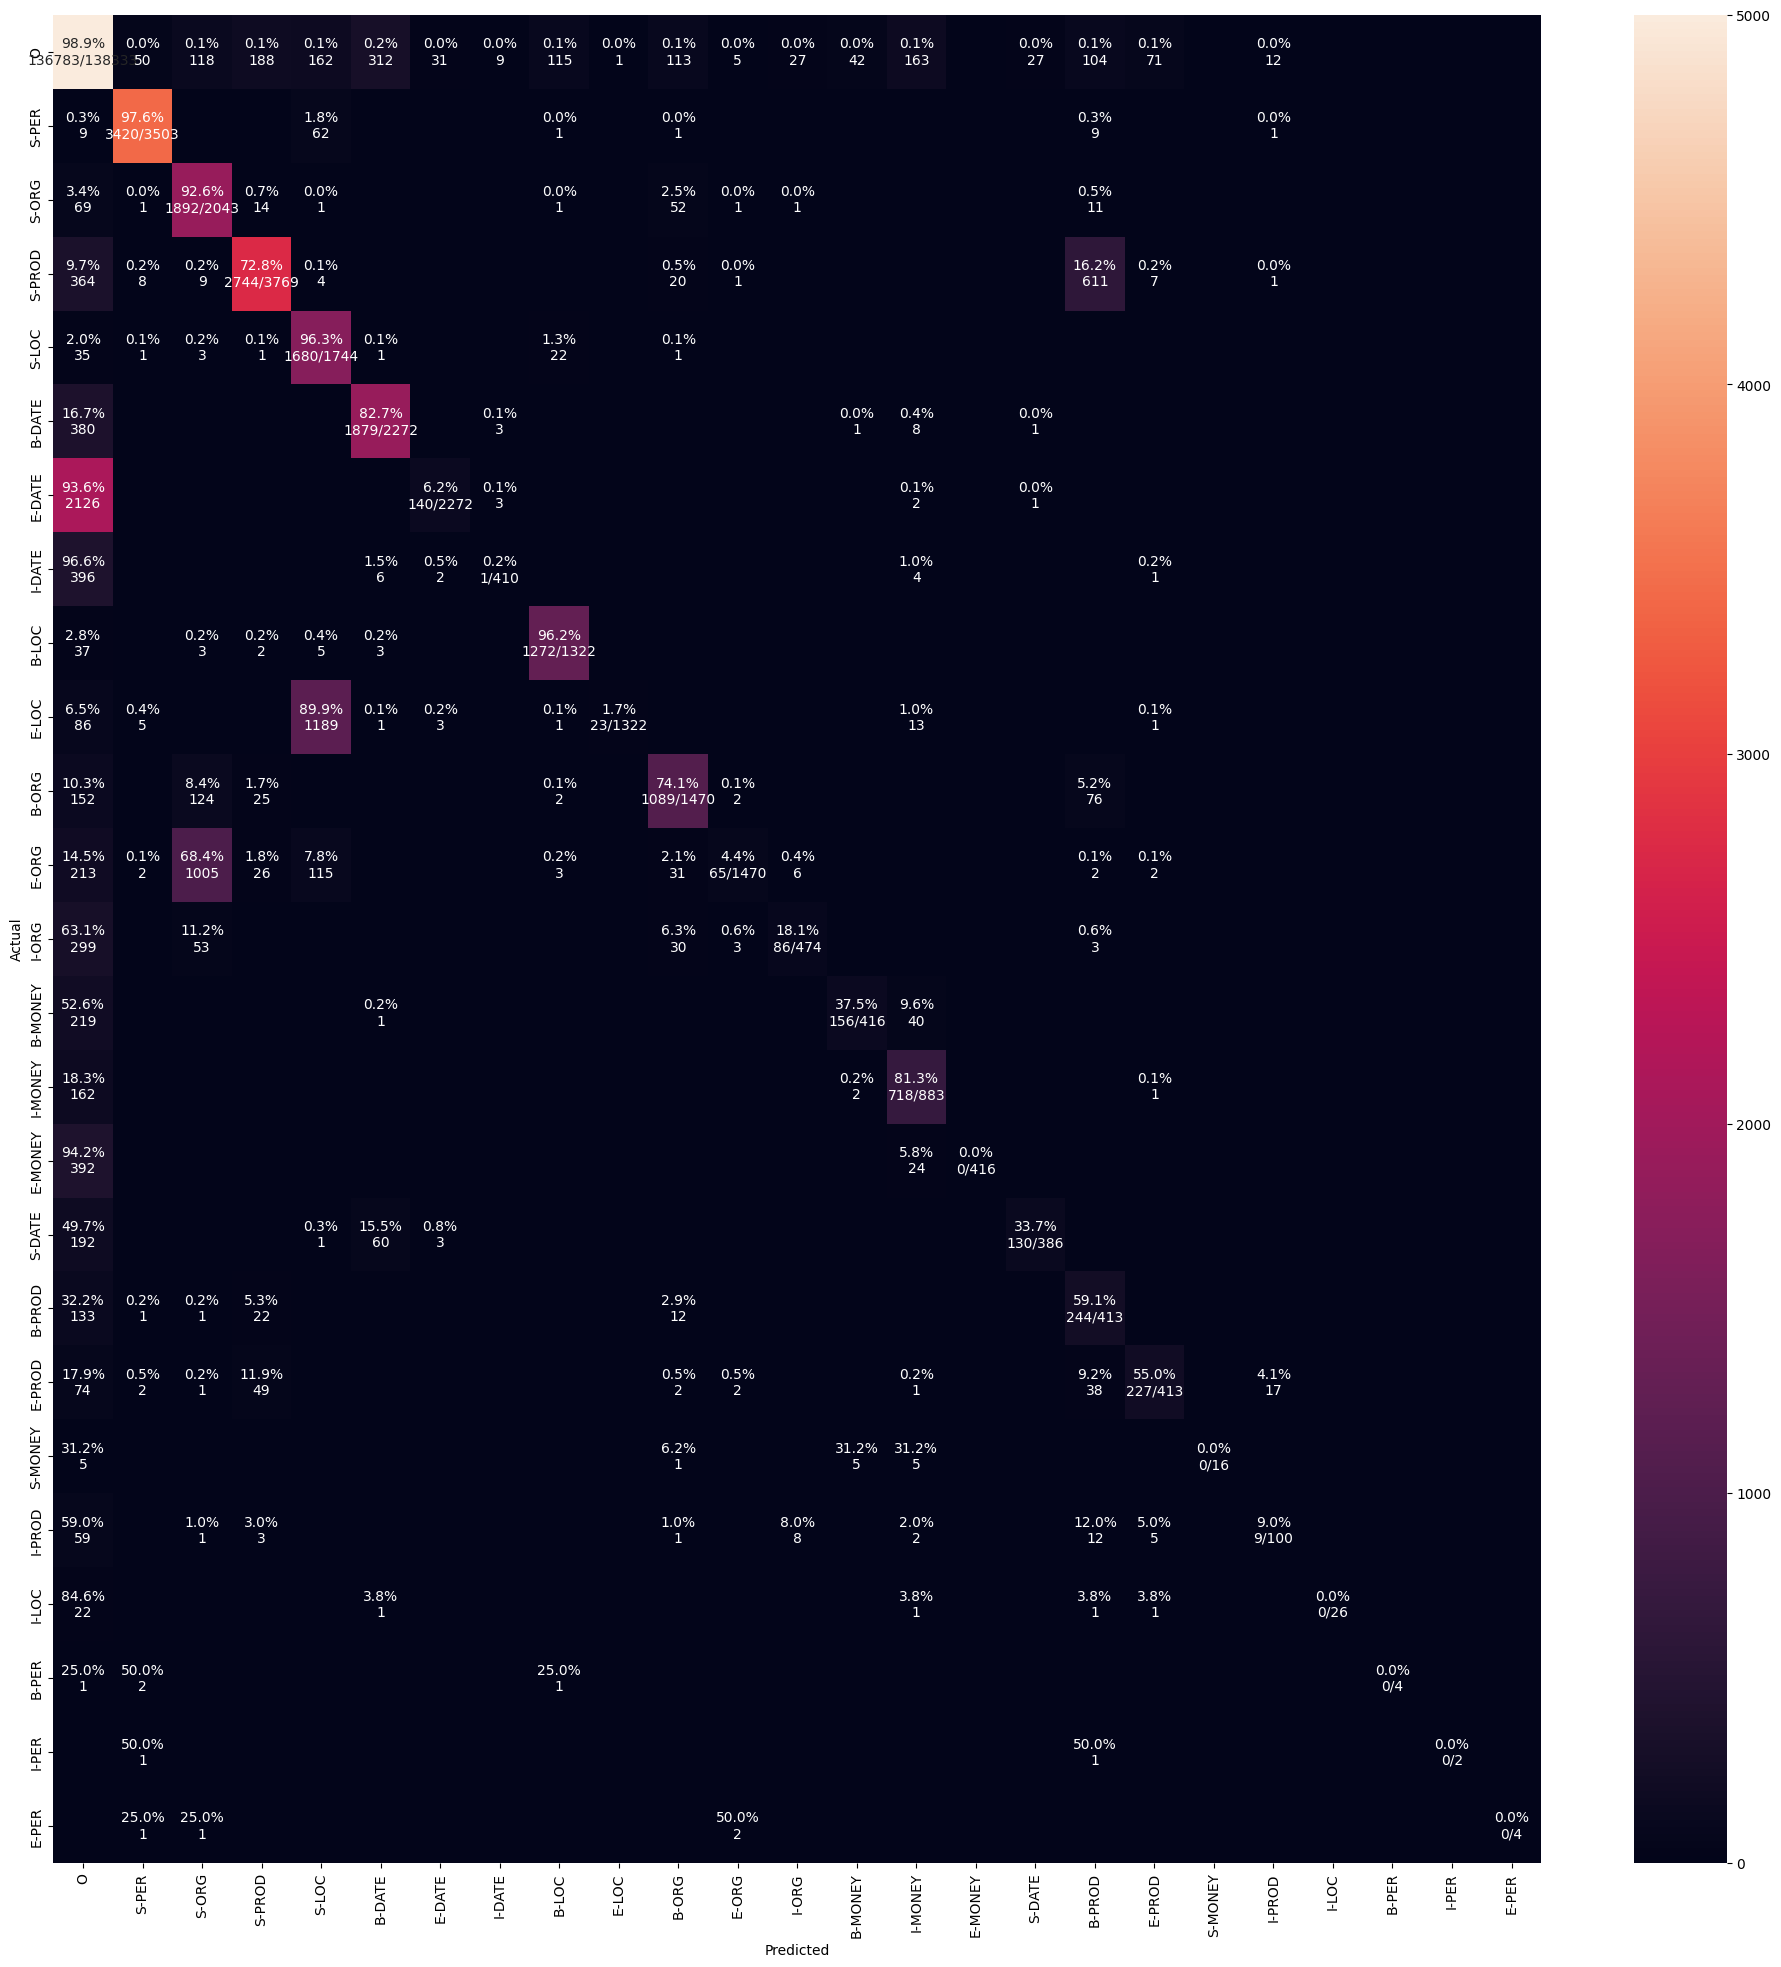

In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args:
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        # change category codes or labels to new labels
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    # calculate a confusion matrix with the new labels
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    # calculate row sums (for calculating % & plot annotations)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    # calculate proportions
    cm_perc = cm / cm_sum.astype(float) * 100
    # empty array for holding annotations for each cell in the heatmap
    annot = np.empty_like(cm).astype(str)
    # get the dimensions
    nrows, ncols = cm.shape
    # cycle over cells and create annotations for each cell
    for i in range(nrows):
        for j in range(ncols):
            # get the count for the cell
            c = cm[i, j]
            # get the percentage for the cell
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                # convert the proportion, count, and row sum to a string with pretty formatting
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    # convert the array to a dataframe. To plot by proportion instead of number, use cm_perc in the DataFrame instead of cm
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    # create empty figure with a specified size
    fig, ax = plt.subplots(figsize=figsize)
    # plot the data using the Pandas dataframe. To change the color map, add cmap=..., e.g. cmap = 'rocket_r'
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, vmin=0, vmax=5000)
    #plt.savefig(filename)
    plt.show()


cm_analysis(
    metric_test['LABEL'],
    metric_test['predict'],
    labels=metric_test['LABEL'].unique(), ymap=None, figsize=(24,24))

In [33]:
metric_test['LABEL'].value_counts()

LABEL
O          138333
S-PROD       3769
S-PER        3503
B-DATE       2272
E-DATE       2272
S-ORG        2043
S-LOC        1744
B-ORG        1470
E-ORG        1470
B-LOC        1322
E-LOC        1322
I-MONEY       883
I-ORG         474
B-MONEY       416
E-MONEY       416
B-PROD        413
E-PROD        413
I-DATE        410
S-DATE        386
I-PROD        100
I-LOC          26
S-MONEY        16
B-PER           4
E-PER           4
I-PER           2
Name: count, dtype: int64

In [34]:
metric_test['LABEL_GROUPED_TRUE'] = metric_test['LABEL'].apply(lambda x: x[2:] if len(x)>1 else 'O')
metric_test['LABEL_GROUPED_PRED'] = metric_test['predict'].apply(lambda x: x[2:] if len(x)>1 else 'O')

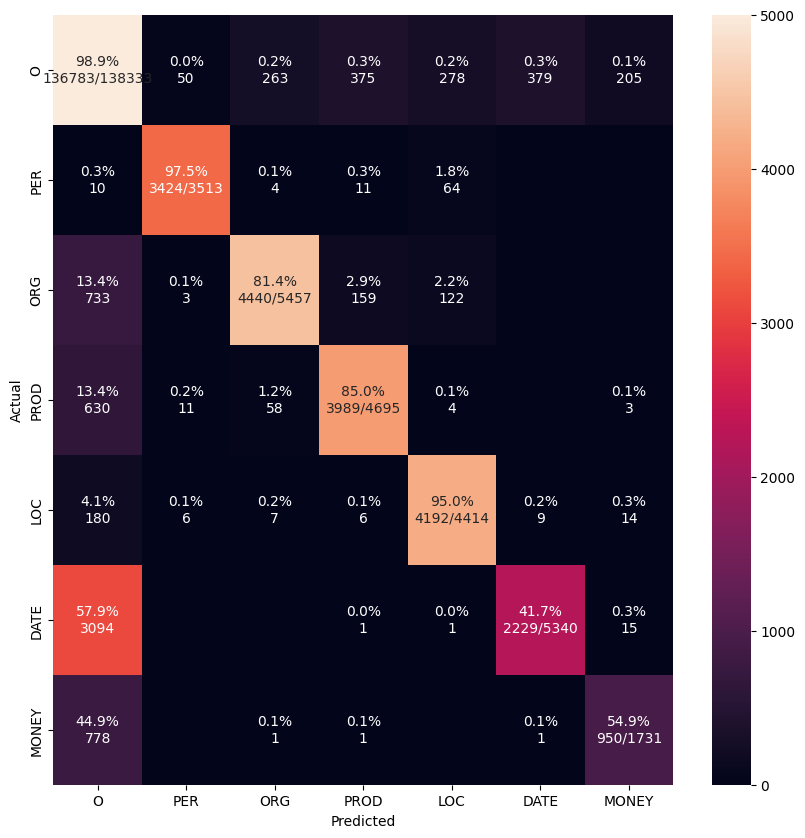

In [35]:
cm_analysis(
    metric_test['LABEL_GROUPED_TRUE'],
    metric_test['LABEL_GROUPED_PRED'],
    labels=metric_test['LABEL_GROUPED_TRUE'].unique(), ymap=None, figsize=(10,10))

In [36]:
metric_test[
    (metric_test['LABEL_GROUPED_TRUE'] != metric_test['LABEL_GROUPED_PRED'])
#     & (metric_test['LABEL_GROUPED_TRUE'] != 'O') 
    & (metric_test['LABEL_GROUPED_PRED'] != 'O')
]['KEYWORD'].value_counts().head(15)

KEYWORD
ближайший     135
течение       120
Санкт          93
Петербурге     91
тысяч          87
Пулково        66
Черри          64
пять           64
Никита         62
автомир        47
Моторс         35
реке           35
ближайшие      34
КИА            32
Лада           32
Name: count, dtype: int64

In [37]:
metric_test.query('KEYWORD == "Санкт"').sample(10)

,KEYWORD,LABEL,predict,LABEL_GROUPED_TRUE,LABEL_GROUPED_PRED
55954,Санкт,B-LOC,B-LOC,LOC,LOC
40501,Санкт,B-LOC,B-LOC,LOC,LOC
8803,Санкт,B-LOC,B-LOC,LOC,LOC
63458,Санкт,B-LOC,B-LOC,LOC,LOC
100865,Санкт,B-LOC,B-LOC,LOC,LOC
151009,Санкт,B-LOC,B-LOC,LOC,LOC
76102,Санкт,B-LOC,B-LOC,LOC,LOC
69778,Санкт,B-LOC,B-LOC,LOC,LOC
93137,Санкт,B-LOC,B-LOC,LOC,LOC
150465,Санкт,B-LOC,B-LOC,LOC,LOC


In [38]:
metric_test.query('KEYWORD == "Никита"').sample(10)

,KEYWORD,LABEL,predict,LABEL_GROUPED_TRUE,LABEL_GROUPED_PRED
26090,Никита,S-PER,S-LOC,PER,LOC
16609,Никита,S-PER,S-LOC,PER,LOC
157085,Никита,S-PER,S-LOC,PER,LOC
103476,Никита,S-PER,S-LOC,PER,LOC
42653,Никита,S-PER,S-LOC,PER,LOC
125604,Никита,S-PER,S-LOC,PER,LOC
56430,Никита,O,S-LOC,O,LOC
14054,Никита,S-PER,S-LOC,PER,LOC
83508,Никита,S-PER,S-LOC,PER,LOC
49624,Никита,S-PER,S-LOC,PER,LOC


In [39]:
metric_test.query('KEYWORD == "Пулково"').sample(10)

,KEYWORD,LABEL,predict,LABEL_GROUPED_TRUE,LABEL_GROUPED_PRED
23868,Пулково,O,S-LOC,O,LOC
23220,Пулково,S-LOC,S-LOC,LOC,LOC
100413,Пулково,E-ORG,S-LOC,ORG,LOC
40288,Пулково,E-ORG,S-LOC,ORG,LOC
34306,Пулково,E-ORG,S-LOC,ORG,LOC
37434,Пулково,E-ORG,S-LOC,ORG,LOC
107510,Пулково,E-ORG,S-LOC,ORG,LOC
123168,Пулково,E-ORG,S-LOC,ORG,LOC
47138,Пулково,S-LOC,S-LOC,LOC,LOC
104506,Пулково,S-PROD,S-LOC,PROD,LOC


# Тест модели при разбивке по словам

In [42]:
metric_test.LABEL.value_counts()

LABEL
O          138333
S-PROD       3769
S-PER        3503
B-DATE       2272
E-DATE       2272
S-ORG        2043
S-LOC        1744
B-ORG        1470
E-ORG        1470
B-LOC        1322
E-LOC        1322
I-MONEY       883
I-ORG         474
B-MONEY       416
E-MONEY       416
B-PROD        413
E-PROD        413
I-DATE        410
S-DATE        386
I-PROD        100
I-LOC          26
S-MONEY        16
B-PER           4
E-PER           4
I-PER           2
Name: count, dtype: int64

In [43]:
train_w, test_w = train_test_split(metric_test, test_size=0.2, random_state=1) #, stratify
train_w, dev_w = train_test_split(train_w, test_size=0.25, random_state=1)

train_w = train_w.reset_index(drop=True)
test_w = test_w.reset_index(drop=True)
dev_w = dev_w.reset_index(drop=True)

train_w.shape[0], test_w.shape[0], dev_w.shape[0]

(98089, 32697, 32697)

In [44]:
def creating_spacy_data(df, name='train'):
    '''
    from df[['KEYWORD', 'LABEL']] to *.spacy
    '''

    l1=[]
    l2=[]

    for i in range(0,len(df['KEYWORD'])):
        l1.append(df['KEYWORD'][i])
        #l2.append({'entities':[(0,len(df['KEYWORD'][i]),df['LABEL'][i])]})
        l2.append([(0,len(df['KEYWORD'][i]),df['LABEL'][i])])
    DATA = list(zip(l1,l2))

    nlp = spacy.blank("ru")
    db = DocBin()
    for text, annotations in DATA:
        #print(text)
        #print(annotations)
        doc = nlp(text)
        ents = []
        for start, end, label in annotations:
            span = doc.char_span(start, end, label=label)
            ents.append(span)
        doc.ents = ents
        db.add(doc)
    db.to_disk(f"./{name}_w.spacy")

In [45]:
creating_spacy_data(train_w, 'train')
creating_spacy_data(test_w, 'test')
creating_spacy_data(dev_w, 'dev')

In [50]:
config_file = configparser.ConfigParser()

s_config = """
# This is an auto-generated partial config. To use it with 'spacy train'
# you can run spacy init fill-config to auto-fill all default settings:
# python -m spacy init fill-config ./base_config.cfg ./config.cfg
[paths]
train = null
dev = null
vectors = null
[system]
gpu_allocator = null

[nlp]
lang = "ru"
pipeline = ["tok2vec","ner"]
batch_size = 1000

[components]

[components.tok2vec]
factory = "tok2vec"

[components.tok2vec.model]
@architectures = "spacy.Tok2Vec.v2"

[components.tok2vec.model.embed]
@architectures = "spacy.MultiHashEmbed.v2"
width = ${components.tok2vec.model.encode.width}
attrs = ["NORM", "PREFIX", "SUFFIX", "SHAPE"]
rows = [5000, 1000, 2500, 2500]
include_static_vectors = true

[components.tok2vec.model.encode]
@architectures = "spacy.MaxoutWindowEncoder.v2"
width = 256
depth = 8
window_size = 1
maxout_pieces = 3

[components.ner]
factory = "ner"

[components.ner.model]
# @architectures = "spacy.TransitionBasedParser.v2"
#state_type = "ner"
#extra_state_tokens = false
#hidden_width = 64
#maxout_pieces = 2
#use_upper = true
#nO = null

[components.ner.model.tok2vec]
#@architectures = "spacy.Tok2VecListener.v1"
#width = ${components.tok2vec.model.encode.width}

[corpora]

[corpora.train]
@readers = "spacy.Corpus.v1"
path = ${paths.train}
max_length = 0

[corpora.dev]
@readers = "spacy.Corpus.v1"
path = ${paths.dev}
max_length = 0

[training]
dev_corpus = "corpora.dev"
train_corpus = "corpora.train"
patience = 800

[training.optimizer]
@optimizers = "Adam.v1"
learn_rate = 0.0002

[training.batcher]
@batchers = "spacy.batch_by_words.v1"
discard_oversize = false
tolerance = 0.2

[training.batcher.size]
@schedules = "compounding.v1"
start = 100
stop = 1000
compound = 1.001

[initialize]
vectors = ${paths.vectors}
"""
buf = io.StringIO(s_config)
config_file.read_file(buf)

with open("base_config_w.cfg","w") as file_object:
    config_file.write(file_object)

In [51]:
!python -m spacy init fill-config base_config_w.cfg config.cfg

✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [52]:
!python -m spacy train config.cfg --output ./output_w --paths.train ./train_w.spacy --paths.dev ./dev_w.spacy

✔ Created output directory: output_w
ℹ Saving to output directory: output_w
ℹ Using CPU

=========================== Initializing pipeline ===========================
[2023-11-07 06:56:54,779] [INFO] Set up nlp object from config
[2023-11-07 06:56:54,826] [INFO] Pipeline: ['tok2vec', 'ner']
[2023-11-07 06:56:54,834] [INFO] Created vocabulary
[2023-11-07 06:56:54,834] [INFO] Finished initializing nlp object
[2023-11-07 06:57:19,577] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.0002
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     99.02   80.48   80.48   80.48    0.80
  0     200          0.00   6955.39   92.19   92.19   92.19    0.92
  0     400          0.00   2692.41   95.03   95.03   95.03    0.95
  0

In [54]:
%%time
!python -m spacy evaluate /kaggle/working/output_w/model-best --output metrics_w.json ./test_w.spacy

ℹ Using CPU

================================== Results ==================================

TOK     100.00
NER P   96.80 
NER R   96.80 
NER F   96.80 
SPEED   505   


=============================== NER (per type) ===============================

              P       R       F
B-MONEY   76.14   72.83   74.44
O         98.67   98.41   98.54
I-MONEY   73.89   88.36   80.48
B-ORG     86.44   81.99   84.16
B-LOC     91.92   98.20   94.96
I-ORG     62.03   46.23   52.97
S-ORG     93.00   93.00   93.00
B-DATE    81.58   90.77   85.93
S-PER     97.71   99.13   98.41
S-PROD    85.16   90.75   87.87
B-PROD    63.38   54.22   58.44
S-LOC     86.53   92.07   89.22
E-DATE    85.98   95.36   90.43
E-ORG     88.57   79.74   83.93
E-PROD    87.72   60.24   71.43
I-DATE    73.40   79.31   76.24
E-LOC     90.70   94.74   92.67
E-MONEY   80.72   85.90   83.23
I-PROD     0.00    0.00    0.00
S-DATE    85.00   44.74   58.62
B-PER      0.00    0.00    0.00
I-LOC      0.00    0.00    0.00
S-MONEY    0.00

In [55]:
nlp_trained_w = spacy.load('/kaggle/working/output_w/model-best')

In [88]:
doc = nlp_trained_w(test.sample().values[0][0])
displacy.render(doc, style='ent', jupyter=True)

In [94]:
doc = nlp_trained_w(test.sample().values[0][0])
displacy.render(doc, style='ent', jupyter=True)

In [77]:
def predict_model_test_w(text):
    doc = nlp_trained_w(text)
    return [ent.label_ for ent in doc.ents] #ents_label

In [78]:
metric_test['predict_w'] = metric_test['KEYWORD'].progress_apply(lambda x: predict_model_test_w(x))

100%|██████████| 163483/163483 [41:33<00:00, 65.56it/s] 


In [81]:
metric_test

,KEYWORD,LABEL,predict,LABEL_GROUPED_TRUE,LABEL_GROUPED_PRED,predict_w
0,Скажем,O,O,O,O,O
1,так,O,O,O,O,O
2,",",O,O,O,O,O
3,на,O,O,O,O,O
4,.,O,O,O,O,O
...,...,...,...,...,...,...
163478,вы,O,O,O,O,O
163479,взяли,O,O,O,O,O
163480,",",O,O,O,O,O
163481,что,O,O,O,O,O


In [80]:
metric_test['predict_w'] = metric_test['predict_w'].apply(lambda x: x[0] if len(x)!=0 else np.nan)

In [82]:
metric_test['LABEL'].value_counts()

LABEL
O          138333
S-PROD       3769
S-PER        3503
B-DATE       2272
E-DATE       2272
S-ORG        2043
S-LOC        1744
B-ORG        1470
E-ORG        1470
B-LOC        1322
E-LOC        1322
I-MONEY       883
I-ORG         474
B-MONEY       416
E-MONEY       416
B-PROD        413
E-PROD        413
I-DATE        410
S-DATE        386
I-PROD        100
I-LOC          26
S-MONEY        16
B-PER           4
E-PER           4
I-PER           2
Name: count, dtype: int64

In [83]:
metric_test['predict_w'].value_counts()

predict_w
O          137641
S-PROD       4082
S-PER        3547
B-DATE       2567
E-DATE       2478
S-ORG        2126
S-LOC        1875
B-LOC        1413
E-LOC        1408
B-ORG        1349
E-ORG        1345
I-MONEY      1099
I-DATE        485
E-MONEY       462
B-MONEY       398
I-ORG         375
B-PROD        333
E-PROD        287
S-DATE        213
Name: count, dtype: int64

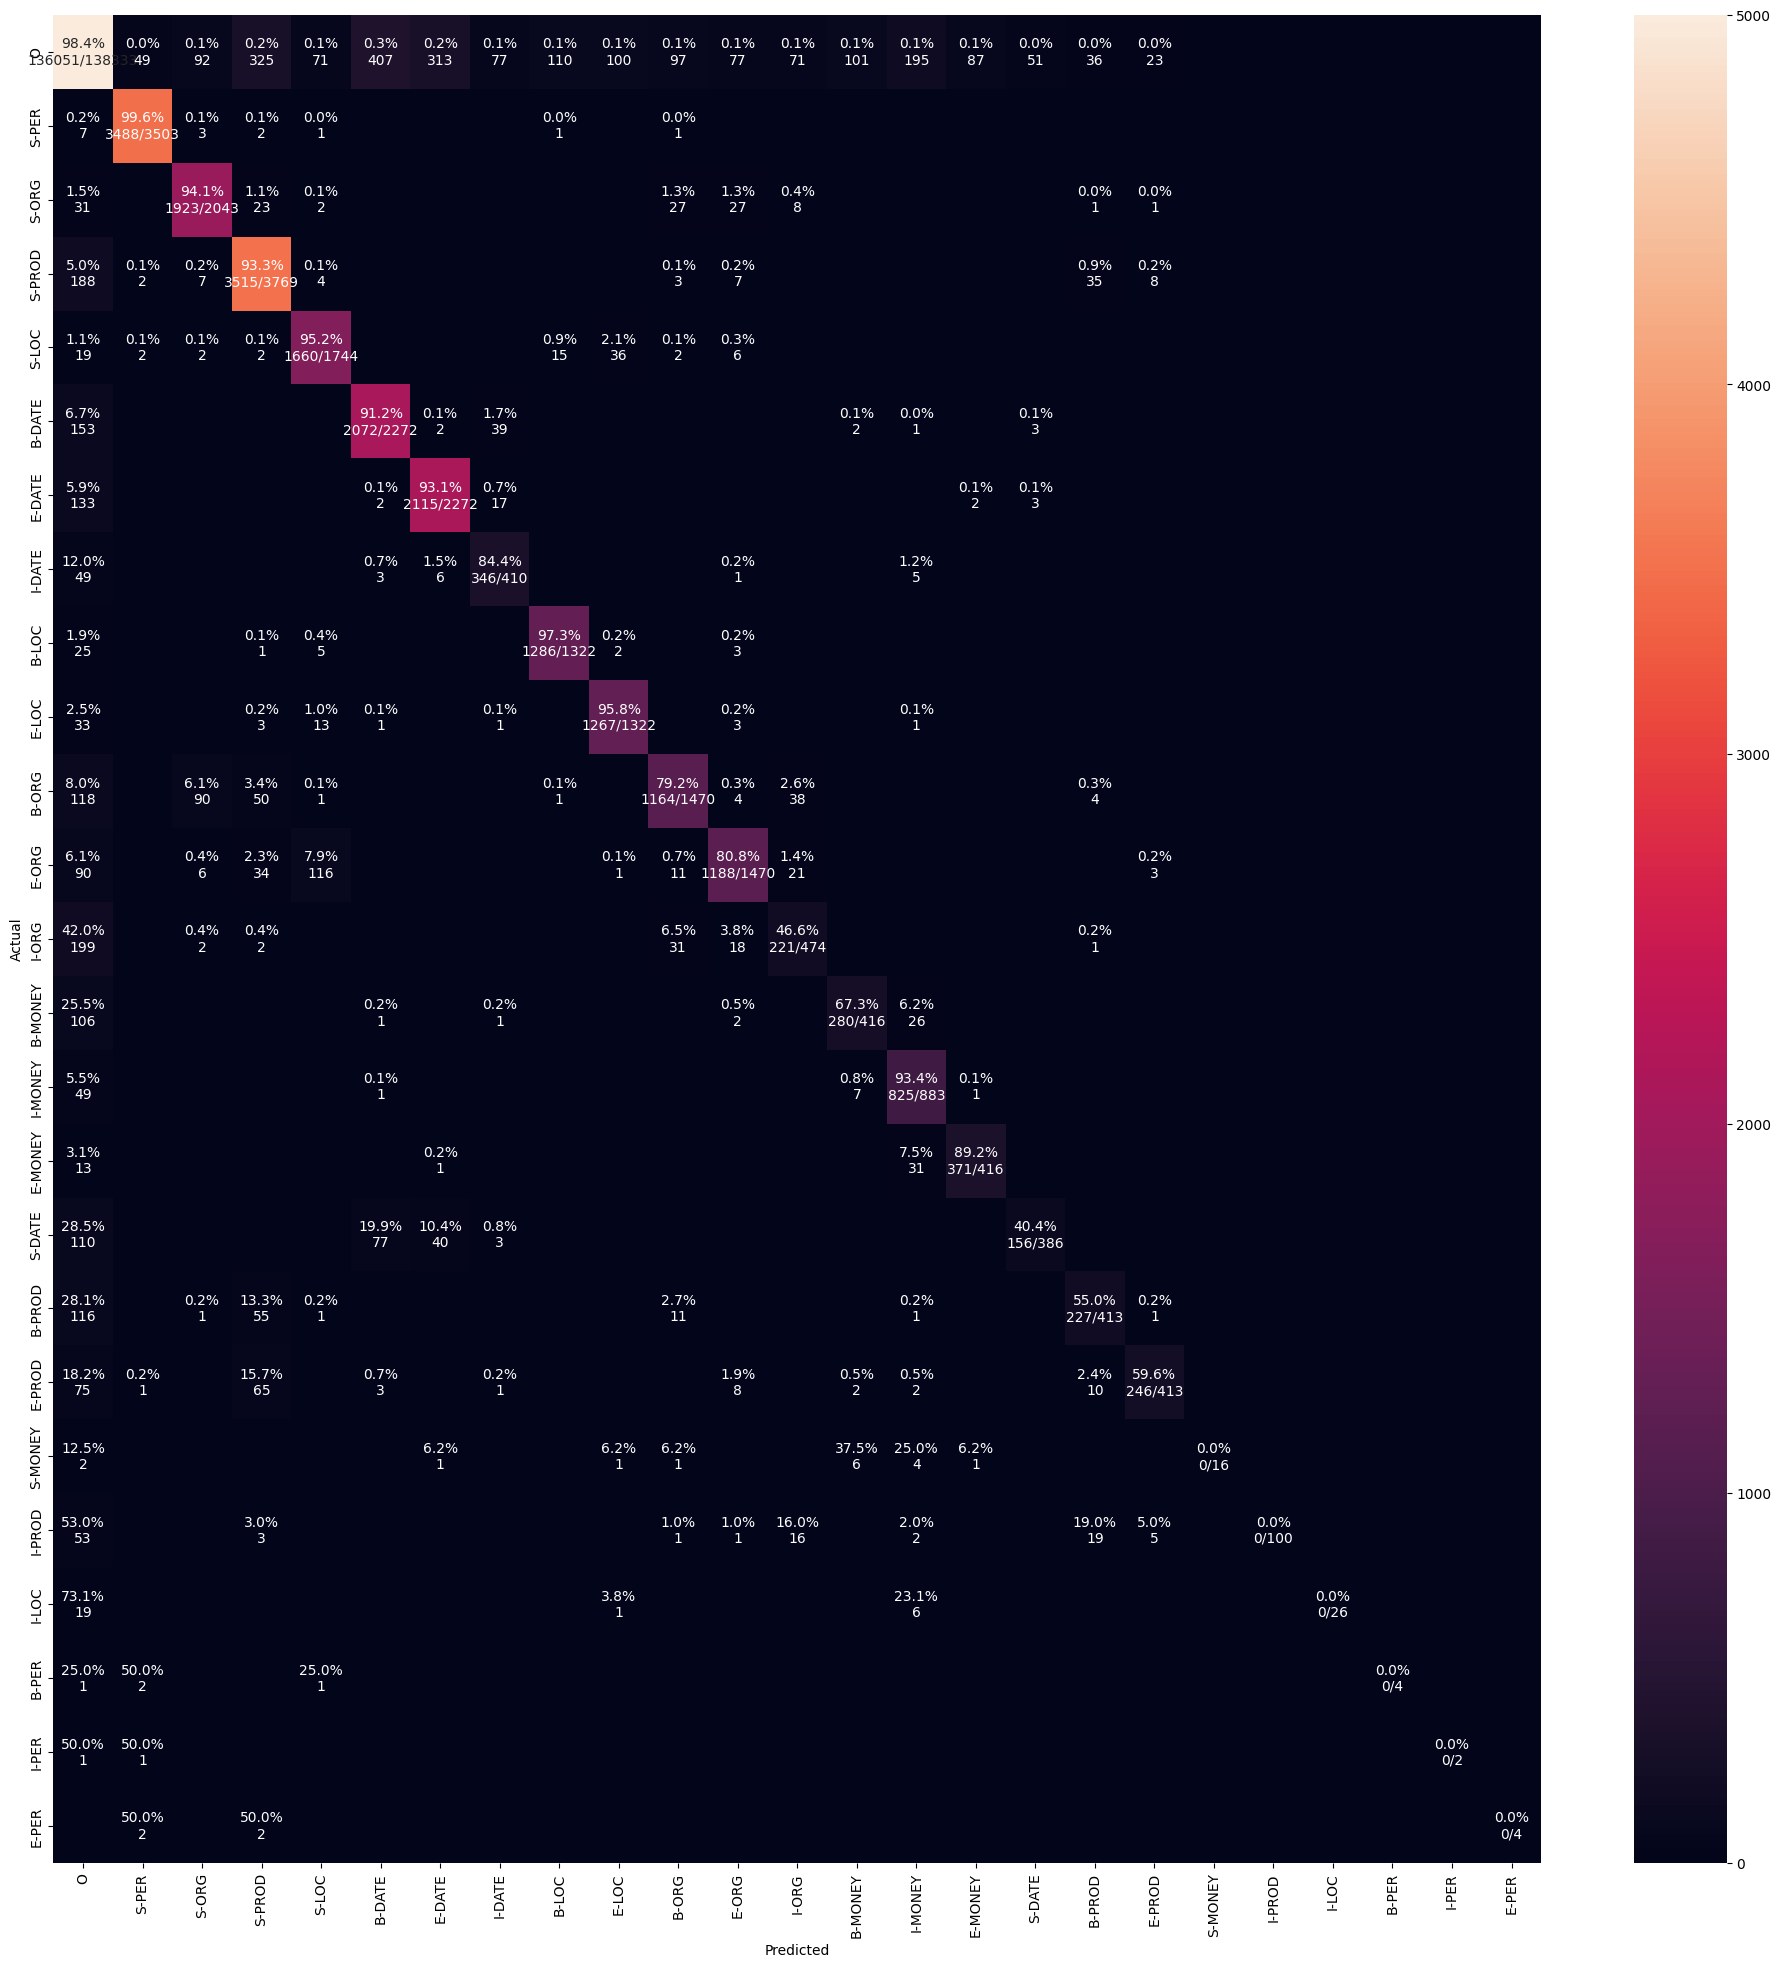

In [84]:
cm_analysis(
    metric_test['LABEL'],
    metric_test['predict_w'],
    labels=metric_test['LABEL'].unique(), ymap=None, figsize=(24,24))

In [85]:
metric_test['LABEL_GROUPED_PRED_W'] = metric_test['predict_w'].apply(lambda x: x[2:] if len(x)>1 else 'O')

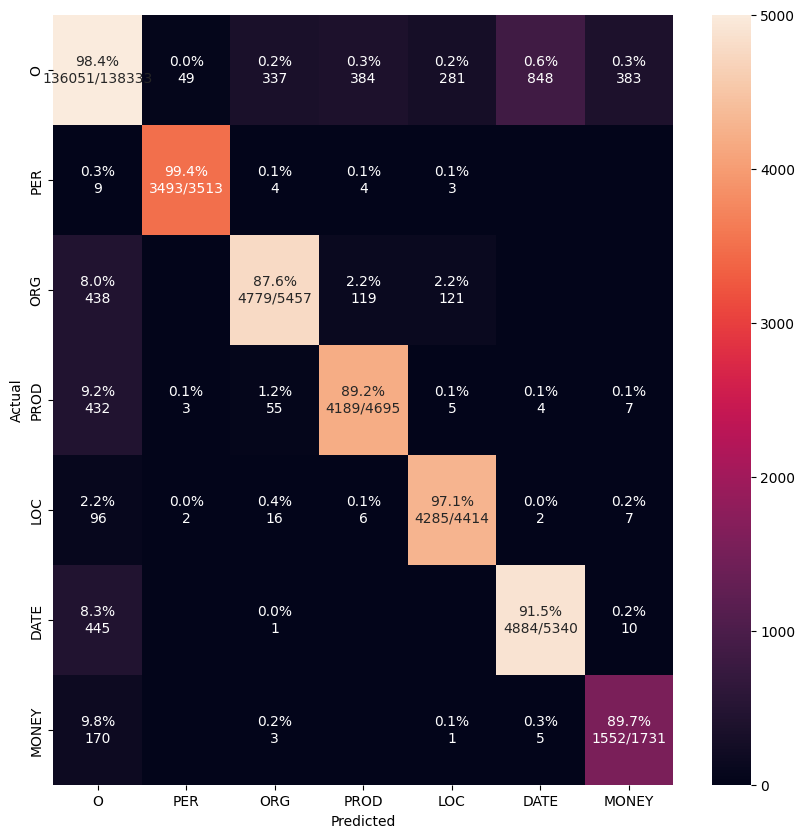

In [86]:
cm_analysis(
    metric_test['LABEL_GROUPED_TRUE'],
    metric_test['LABEL_GROUPED_PRED_W'],
    labels=metric_test['LABEL_GROUPED_TRUE'].unique(), ymap=None, figsize=(10,10))

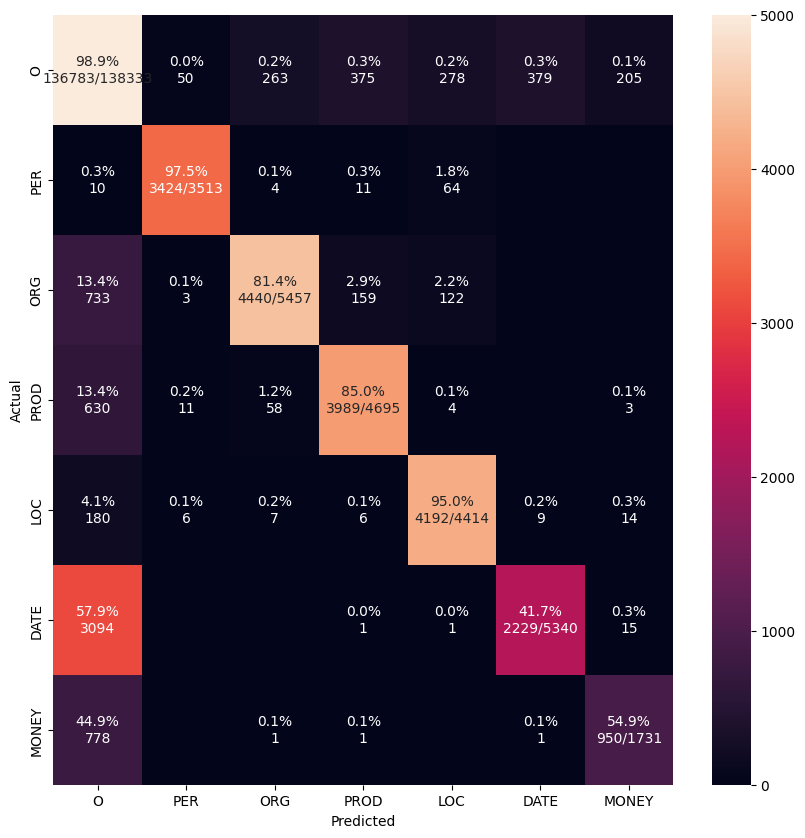

In [87]:
cm_analysis(
    metric_test['LABEL_GROUPED_TRUE'],
    metric_test['LABEL_GROUPED_PRED'],
    labels=metric_test['LABEL_GROUPED_TRUE'].unique(), ymap=None, figsize=(10,10))

In [91]:
metric_test.to_csv('two_models_test.csv', index=False, encoding='utf-8')

In [105]:
doc = nlp_trained_w('Перезвоните в ближайший месяц')
displacy.render(doc, style='ent', jupyter=True)

# ВЫВОД:


В данной работе проведено исследование возможности извлечения именованных сущностей из текстов транскрибированных из диалогов.
Для обучения модели на основе spaCy был взят предварительно размеченный вручную датасет. 
В данном блокноте модель обучается на втором варианте датасета в формате (фраза, ([start, end, тип сущности])) в отличии от первого варианта где обучение просиходило не по фразе а по каждому слову (слово, ([start, end, тип сущности]))

Модель обученная на датасете с пословным разделением, показывает в целом качество выше. А ошибки в основном встречаются в пределах одного класса.

In [92]:
!pip freeze > requirements.txt

In [93]:
from IPython.display import FileLink

os.chdir(r'/kaggle/working/')
!tar -czf spacy_ner.tar.gz /kaggle/working/
FileLink(r'spacy_ner.tar.gz')

tar: Removing leading `/' from member names


/kaggle/working/spacy_ner.tar.gz